In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense,BatchNormalization,Input
from keras.models import Model
from keras.losses import SparseCategoricalCrossentropy 
from keras.optimizers import Adam, SGD, Adagrad, RMSprop
from keras import initializers
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

2024-03-24 00:43:26.150635: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-24 00:43:26.150889: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-24 00:43:26.335987: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
def preprocess_data(feat_path,label_path):
    Data_feat=pd.read_csv(feat_path,header=None)
    Data_label=pd.read_csv(label_path,header=None)
    colums = [f'feature_{i+1}' for i in range(Data_feat.shape[1])]
    Data_feat.columns=colums
    Data_label.columns=['label']
    Data=pd.concat([Data_feat,Data_label],axis=1)
    return Data

In [4]:
def get_shuffled_data(data):
    data=data.sample(frac=1)
    X=data.iloc[:,0:-1].values
    y=data.iloc[:,-1].values
    return X,y

In [5]:
Data_train=preprocess_data("/kaggle/input/iitm-cs6910-assignment-dataset/task1-20240306T145403Z-001/task1/train_data.csv","/kaggle/input/iitm-cs6910-assignment-dataset/task1-20240306T145403Z-001/task1/train_label.csv")
Data_val=preprocess_data("/kaggle/input/iitm-cs6910-assignment-dataset/task1-20240306T145403Z-001/task1/val_data.csv","/kaggle/input/iitm-cs6910-assignment-dataset/task1-20240306T145403Z-001/task1/val_label.csv")
Data_test=preprocess_data("/kaggle/input/iitm-cs6910-assignment-dataset/task1-20240306T145403Z-001/task1/test_data.csv","/kaggle/input/iitm-cs6910-assignment-dataset/task1-20240306T145403Z-001/task1/test_label.csv")

In [6]:
X_train,y_train=get_shuffled_data(Data_train)
X_val,y_val=get_shuffled_data(Data_val)
X_test,y_test=Data_test.iloc[:,0:-1].values,Data_test.iloc[:,-1].values

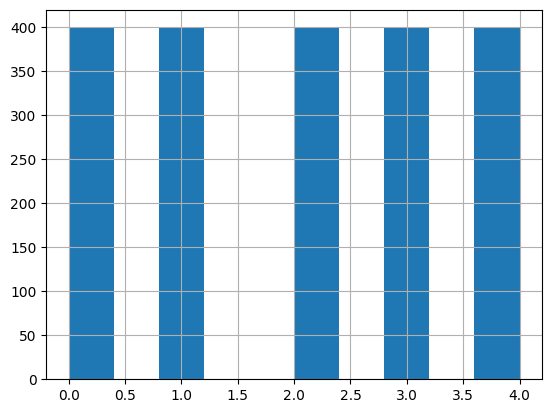

In [7]:
#View the histogram of the train data
Data_train['label'].hist()
plt.show()

**So classes are balanced**

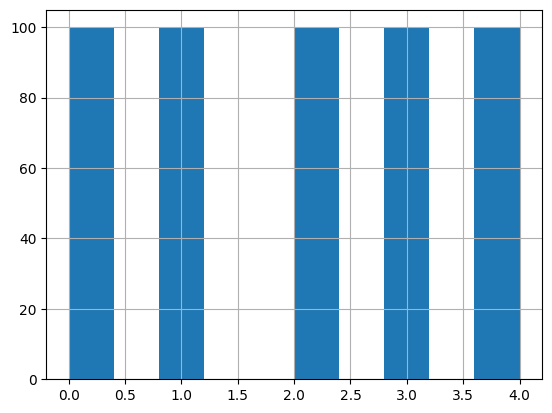

In [8]:
Data_val['label'].hist()
plt.show()

## Model architecture

In [9]:
initializer = initializers.GlorotUniform(seed=42)

def BNFFN(inputs): # Function defining model architecture
    """
    pass a dataframe object
    """
    h1 = tf.keras.layers.Dense(20,activation = 'tanh', kernel_initializer = initializer)(inputs)
    z1 = tf.keras.layers.BatchNormalization(axis = -1)(h1)
    h2 = tf.keras.layers.Dense(10,activation = 'tanh', kernel_initializer = initializer)(z1)
    z2 = tf.keras.layers.BatchNormalization(axis = -1)(h2)
    output = tf.keras.layers.Dense(5,activation = 'softmax', kernel_initializer = initializer)(z2)
    return output

def MLFFN(inputs): # Function defining model architecture
    """
    pass a dataframe object
    """
    h1 = Dense(units = 20, activation = 'tanh', kernel_initializer = initializer)(inputs)
    h2 = Dense(units = 10, activation = 'tanh', kernel_initializer = initializer)(h1)
    output = Dense(units = 5, activation = 'softmax', kernel_initializer = initializer)(h2)
    return output

Loss_fnc=SparseCategoricalCrossentropy()
lr=0.001

In [39]:
def Model_training_loop(inputs,outputs,X_train,y_train,X_val,y_val,optimizer,Loss,optimizer_name:str,epochs=10, batch_size=64):
    """
    optimizer_name: string to get the name of the optimizer
    optimizer: pass the optimizer along with the learning rate
    """
    model = Model(inputs = inputs, outputs = output) 
    model.compile(loss=Loss,optimizer=optimizer,metrics=['acc'])
    earl=EarlyStopping(monitor='val_loss',mode='auto', min_delta=0.001, patience=5,verbose=1)
    filepath = optimizer_name+'_'+'best_model_epoch_{epoch}_val_loss_{val_loss:.4f}.keras'
    chkpt = ModelCheckpoint(filepath=filepath, 
                        monitor='val_loss', 
                        save_best_only=True,verbose=1)
    history=model.fit(X_train,y_train,batch_size=batch_size,validation_data=(X_val,y_val),validation_batch_size=1,epochs=epochs,callbacks=[earl,chkpt])
    
    
    plt.figure(figsize=(10,8))
    plt.title(f"Learning curve with {optimizer_name} optimizer",fontsize=22)
    plt.plot(history.history['loss'],label='Train loss')
    plt.plot(history.history['val_loss'],label='Validation loss')
    plt.legend()
    plt.xlabel('Epochs',fontsize=20)
    plt.ylabel('Loss',fontsize=20)
    plt.savefig(f"Error_{optimizer_name}.png")
    plt.show()
    
    return model

In [13]:
def evaluation(model,x,y_true,opt_name,data_name):
    """
    Pass the trained model along with the data,
    please add the name of the data and optimizer name for the plotting purpose
    """
    labels=np.unique(y_true)
    y_pred=np.argmax(model.predict(x),axis=1)
    CM=confusion_matrix(y_true,y_pred)
    plt.figure(figsize=(10,8))
    plt.title(f"Confusion Matrix for {opt_name} optimizer for {data_name}",fontsize=18)
    sns.heatmap(CM,annot=True,cmap='Pastel2',fmt='d',linewidths=1.0)
    plt.yticks(np.arange(len(labels))+0.5,labels,fontsize=14,rotation='horizontal')
    plt.xticks(np.arange(len(labels))+0.5,labels,fontsize=14)
    plt.xlabel("Predicted",fontsize=16)
    plt.ylabel("Actual",fontsize=16)
    plt.savefig(f"Conf_{opt_name}_{data_name}.png")
    plt.show()

In [14]:
inputs = Input(shape = (36,))
output = BNFFN(inputs)
model = Model(inputs = inputs, outputs = output)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 36)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 20)             │           740 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 20)             │            80 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 10)             │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │            55 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,125 (4.39 KB)

 Trainable params: 1,065 (4.16 KB)

 Non-trainable params: 60 (240.00 B)

In [15]:
X=Data_train.iloc[:,:-1].values

## Check the forward pass before initiating training

In [16]:
inputs = Input(shape = (36,))

## Adam optimizer

Epoch 1/100
25/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.2320 - loss: 1.6038
Epoch 1: val_loss improved from inf to 1.53404, saving model to Adam_best_model_epoch_1_val_loss_1.5340.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - acc: 0.2420 - loss: 1.5989 - val_acc: 0.3260 - val_loss: 1.5340
Epoch 2/100
26/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.4049 - loss: 1.5164 
Epoch 2: val_loss improved from 1.53404 to 1.46286, saving model to Adam_best_model_epoch_2_val_loss_1.4629.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - acc: 0.4052 - loss: 1.5140 - val_acc: 0.4140 - val_loss: 1.4629
Epoch 3/100
25/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.4435 - loss: 1.4461   
Epoch 3: val_loss improved from 1.46286 to 1.38295, saving model to Adam_best_model_epoch_3_val_loss_1.3830.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - acc: 0.4422 - loss: 1.4417 - val_acc: 0.4540 - val_loss: 1.3830
Epoch 4/100
26/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.4825 - loss: 1.3632 
Epoch 4: val_loss i

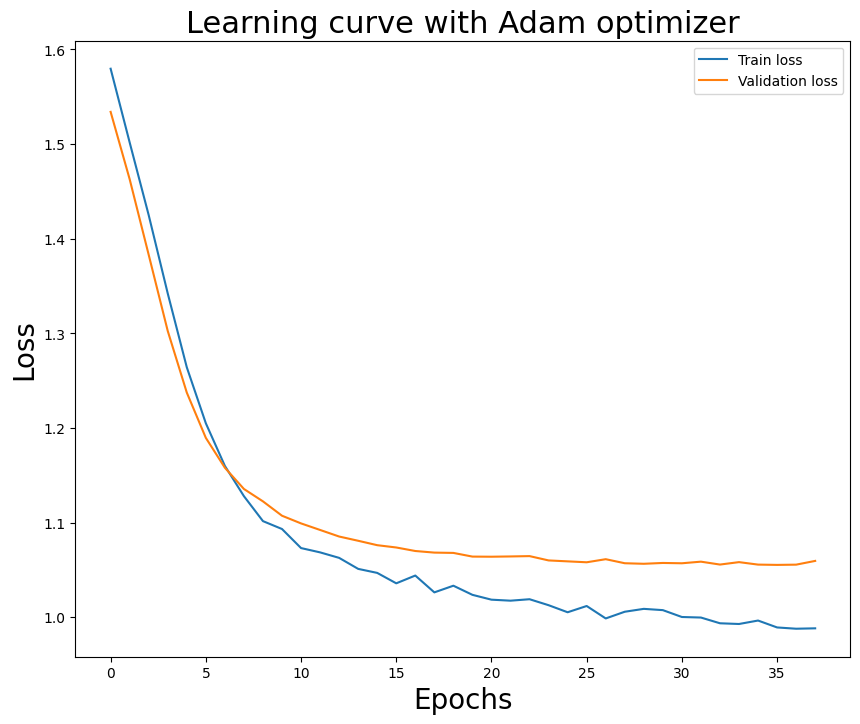

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


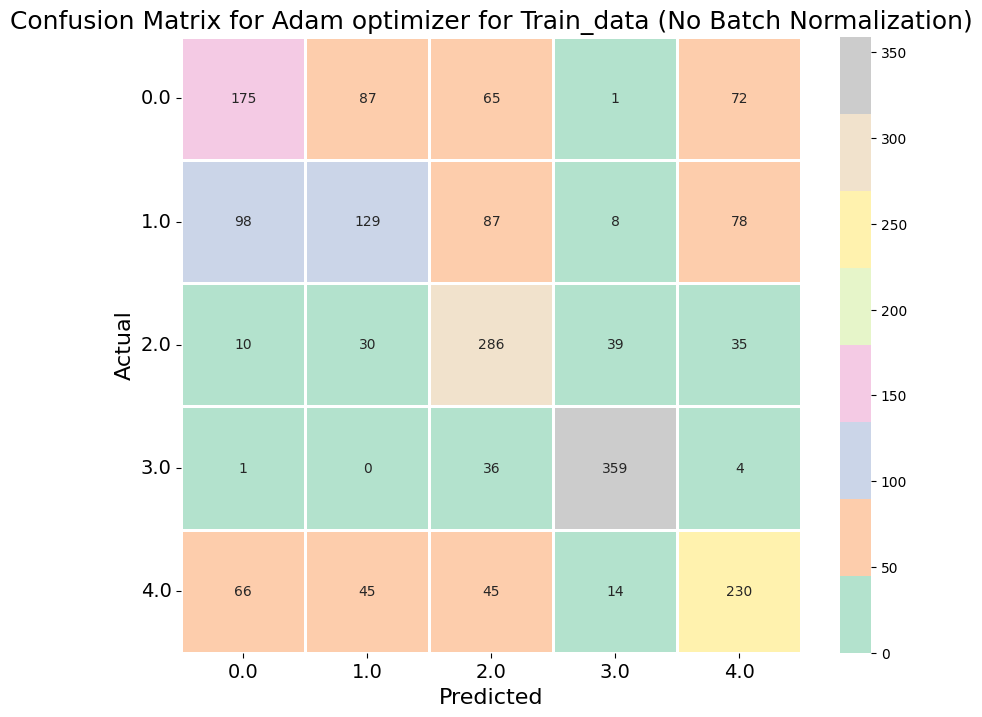

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


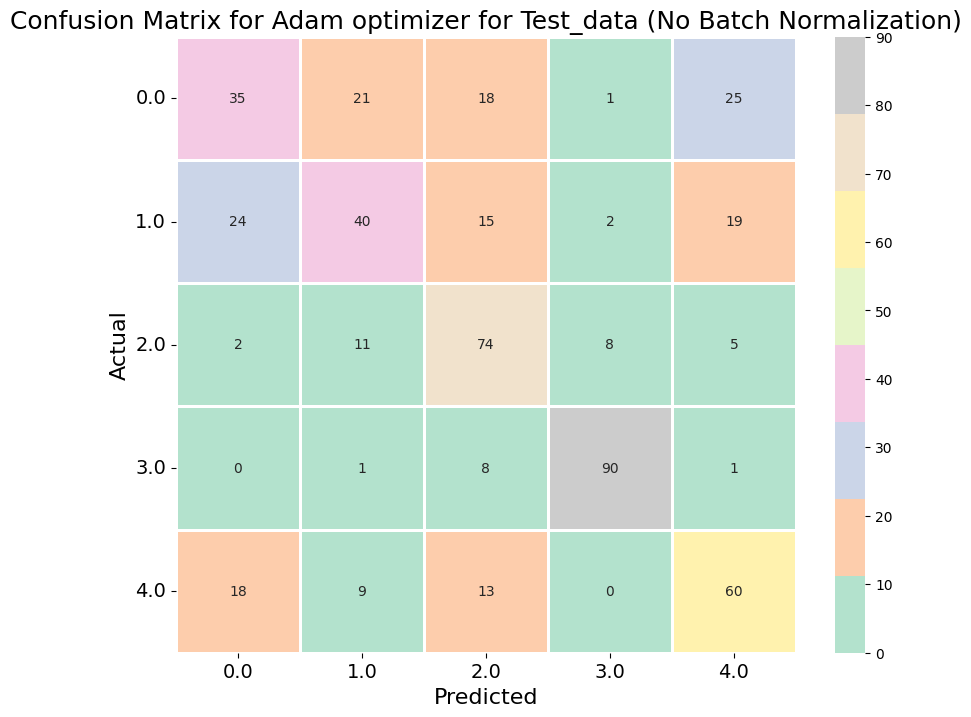

In [42]:
output = MLFFN(inputs)
Trained_model=Model_training_loop(inputs,output,X_train,y_train,X_val,y_val,optimizer=Adam(learning_rate=lr),Loss=Loss_fnc,optimizer_name="Adam (UB)",epochs=100)
evaluation(Trained_model,X_train,y_train,"Adam","Train_data (No Batch Normalization)")
evaluation(Trained_model,X_test,y_test,"Adam","Test_data (No Batch Normalization)")

## Adam Optimiser (Batch Normallised)


Epoch 1/100
17/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 0.2615 - loss: 1.7989 
Epoch 1: val_loss improved from inf to 1.54974, saving model to Adam_best_model_epoch_1_val_loss_1.5497.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - acc: 0.2797 - loss: 1.7430 - val_acc: 0.2900 - val_loss: 1.5497
Epoch 2/100
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 0.4288 - loss: 1.3718 
Epoch 2: val_loss improved from 1.54974 to 1.49061, saving model to Adam_best_model_epoch_2_val_loss_1.4906.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - acc: 0.4290 - loss: 1.3703 - val_acc: 0.3320 - val_loss: 1.4906
Epoch 3/100
17/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 0.4904 - loss: 1.2273 
Epoch 3: val_loss improved from 1.49061 to 1.44415, saving model to Adam_best_model_epoch_3_val_loss_1.4441.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - acc: 0.4829 - loss: 1.2370 - val_acc: 0.3840 - val_loss: 1.4441
Epoch 4/100
18/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 0.4943 - loss: 1.1653 
Epoch 4: val_loss im

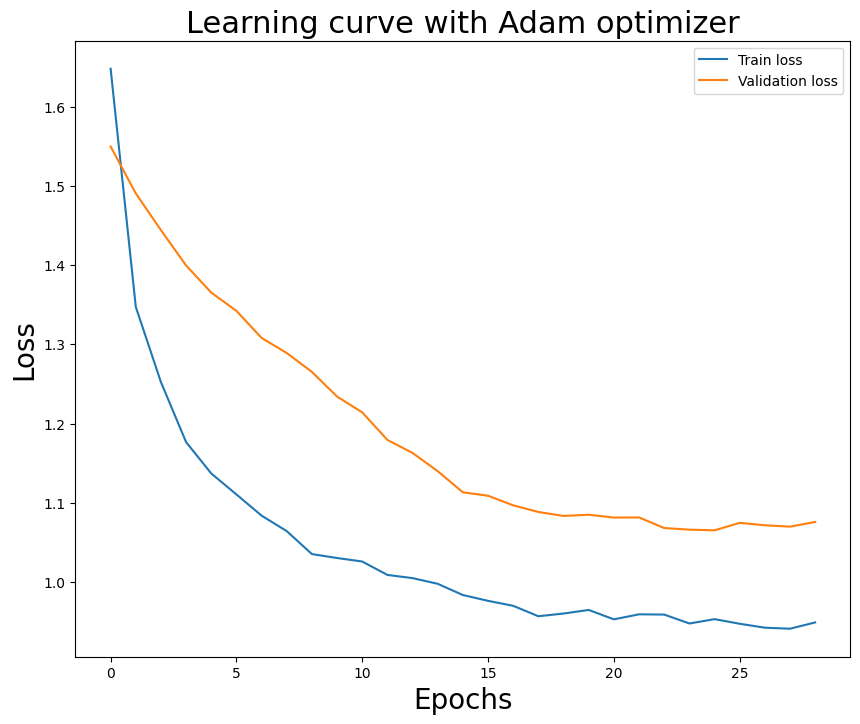

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


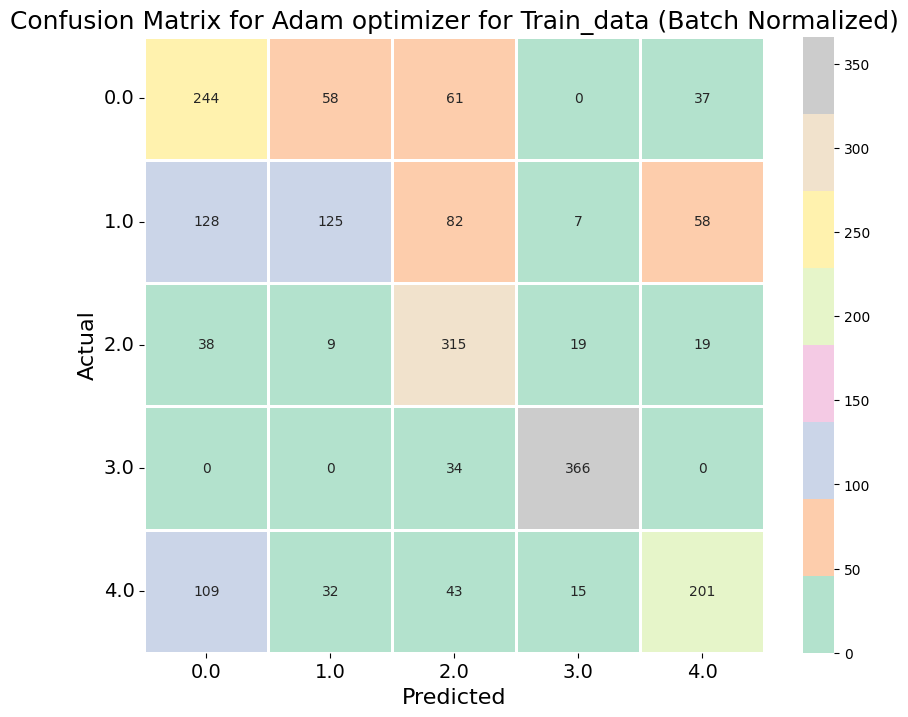

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


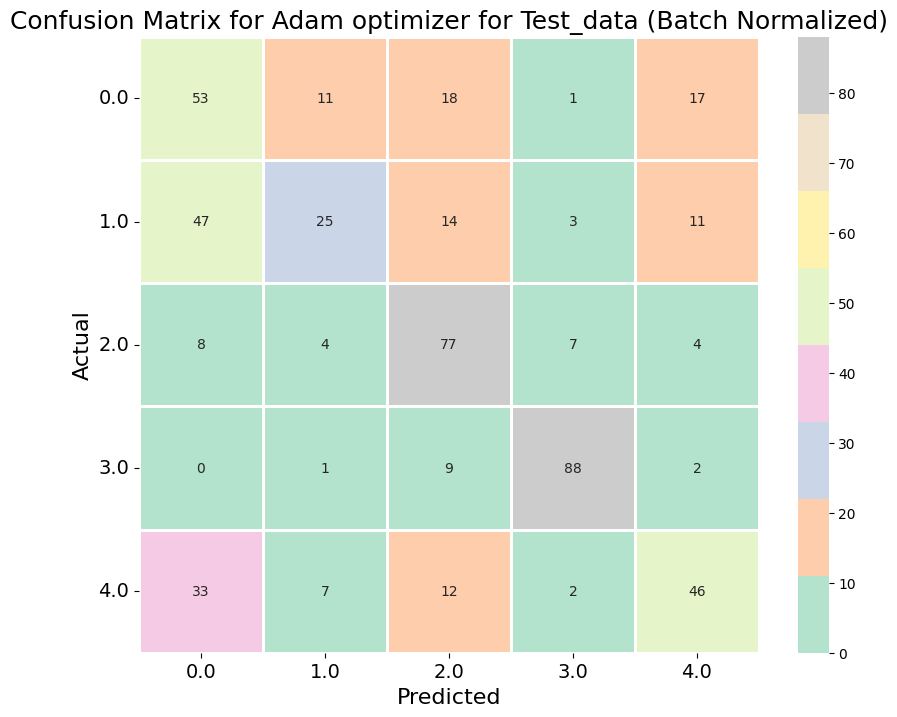

In [43]:
output = BNFFN(inputs)
Trained_model=Model_training_loop(inputs,output,X_train,y_train,X_val,y_val,optimizer=Adam(learning_rate=lr),Loss=Loss_fnc,optimizer_name="Adam (BN)",epochs=100)
evaluation(Trained_model,X_train,y_train,"Adam","Train_data (Batch Normalized)")
evaluation(Trained_model,X_test,y_test,"Adam","Test_data (Batch Normalized)")